In [3]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

In [4]:
from keras import layers
from keras.callbacks import TensorBoard

from keras.models import Sequential, Model

from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences

from collections import OrderedDict

from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [35]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [36]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [37]:
!mkdir -p /home/jupyter/data/wordvec/

In [38]:
!gsutil cp -n 'gs://msca-bdp-data-open/wordvec/glove.6B.100d.txt' '/home/jupyter/data/wordvec/'

Skipping existing item: file:///home/jupyter/data/wordvec/glove.6B.100d.txt


In [39]:
mob_load = pd.read_csv("mobile__multi_sent.csv")

In [40]:
mob_load['sentiment'].value_counts()

 1    52197
 0    35080
-1    17572
Name: sentiment, dtype: int64

In [41]:
#Column with clean text
textVar = mob_load["text"]

#Target columns (sentiment, class, etc.)
targetVar = mob_load["sentiment"]

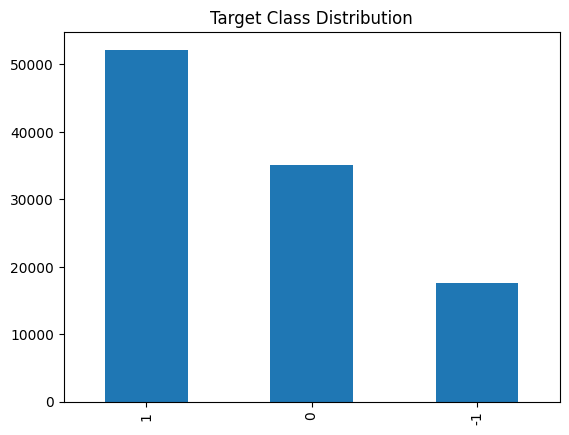

In [42]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

In [43]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our RNN layer
gru_dims = 64

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 10

# Prepossessing parameters
# We will only input the first "sequence_length" words of every Yelp review (and pad out with nulls if the text is < "sequence_length
# We will also build our model using the most frequent 20000 words in our tweet 'dictionary'
sequence_length = 200
max_features = 20000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
#num_classes = 1
num_classes = targetVar.nunique()

In [44]:
# encoder = preprocessing.LabelEncoder()
# encoder.fit(targetVar)

X = textVar.values
Y = pd.get_dummies(targetVar).values

In [45]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X,Y, stratify=targetVar, test_size = 0.33, random_state = 0)

In [46]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_labels.shape)
print(val_samples.shape,val_labels.shape)

(70248,) (70248, 3)
(34601,) (34601, 3)


In [47]:
vectorizer = TextVectorization(max_tokens  = max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [48]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'it']

In [49]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in val_samples])).numpy()

Y_train = np.array(train_labels)
Y_test = np.array(val_labels)

In [50]:
embeddings_index = {}

glove_dir = '/home/jupyter/data/wordvec/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [51]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [52]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15572 words (4428 misses)


In [53]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [54]:
# Model architecture from: https://www.kaggle.com/yekenot/pooled-gru-fasttext

inputs = Input(shape=(sequence_length, ))

x = Embedding(num_tokens, embedding_dim, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)

# Create a concatenation of GlobalAveragePooling1D and GlobalMaxPooling1D layers
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concatenated = concatenate([avg_pool, max_pool])
outputs = Dense(3, activation="softmax")(concatenated)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 100)     2000200     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 200, 100)    0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 200, 128)    63744       ['spatial_dropout1d_1[0][0]

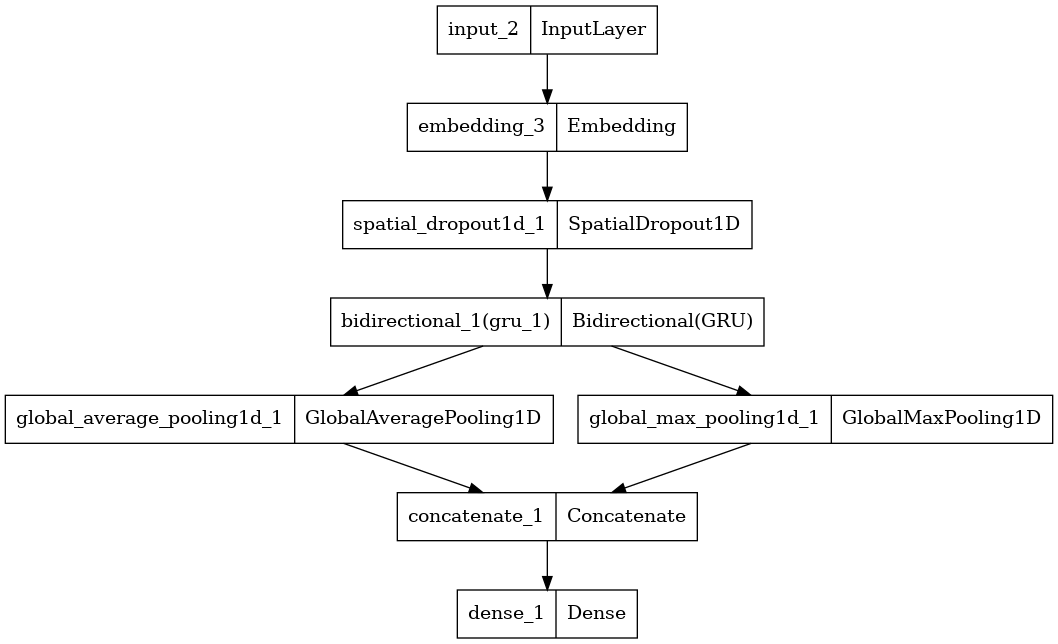

In [55]:
tf.keras.utils.plot_model(model)

In [56]:
filepath="/home/jupyter/data/dl_models/gru_glove_weights_best"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

GRU_glove_history = history

Epoch 1/10
1098/1098 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.7343
Epoch 1: val_accuracy improved from -inf to 0.79449, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 38s 32ms/step - loss: 0.5877 - accuracy: 0.7343 - val_loss: 0.4725 - val_accuracy: 0.7945
Epoch 2/10
1096/1098 [============================>.] - ETA: 0s - loss: 0.4562 - accuracy: 0.8034
Epoch 2: val_accuracy improved from 0.79449 to 0.80110, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 32s 29ms/step - loss: 0.4560 - accuracy: 0.8035 - val_loss: 0.4611 - val_accuracy: 0.8011
Epoch 3/10
1097/1098 [============================>.] - ETA: 0s - loss: 0.4138 - accuracy: 0.8251
Epoch 3: val_accuracy improved from 0.80110 to 0.80382, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 34s 31ms/step - loss: 0.4137 - accuracy: 0.8251 - val_loss: 0.4597 - val_accuracy: 0.8038
Epoch 4/10
1098/1098 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8418
Epoch 4: val_accuracy did not improve from 0.80382
1098/1098 [==============================] - 21s 19ms/step - loss: 0.3769 - accuracy: 0.8418 - val_loss: 0.4683 - val_accuracy: 0.8028
Epoch 5/10
1098/1098 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8602
Epoch 5: val_accuracy did not improve from 0.80382
1098/1098 [==============================] - 23s 21ms/step - loss: 0.3404 - accuracy: 0.8602 - val_loss: 0.4963 - val_accuracy: 0.7974
Epoch 6/10
1096/1098 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8771
Epoch 6: val_accuracy did not improve from 0.80382
1098/1098 [==============================] - 21s 19ms/step - loss: 0.3052 - accuracy: 0.8771 - val_loss: 0.5118 - val_accuracy: 0.7948
Epoch 7/10
10

In [57]:
!ls -l "/home/jupyter/data/dl_models/gru_glove_weights_best"

total 1964
drwxr-xr-x 2 jupyter jupyter    4096 May 22 08:09 assets
-rw-r--r-- 1 jupyter jupyter   21877 May 24 22:23 keras_metadata.pb
-rw-r--r-- 1 jupyter jupyter 1974355 May 24 22:23 saved_model.pb
drwxr-xr-x 2 jupyter jupyter    4096 May 24 22:23 variables


In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['accuracy'], 'orange', label='Training acc')
    plt.plot(epochs, h['val_accuracy'], 'blue', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

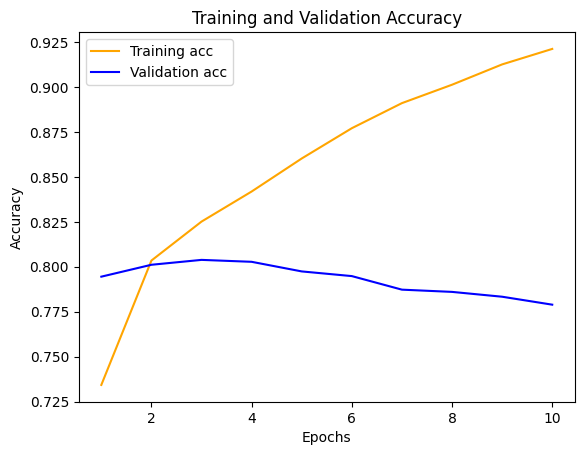

In [60]:
plot_train(GRU_glove_history)

In [61]:
def plot_loss(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['loss'], 'orange', label='Training loss')
    plt.plot(epochs, h['val_loss'], 'blue', label='Validation loss')  
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

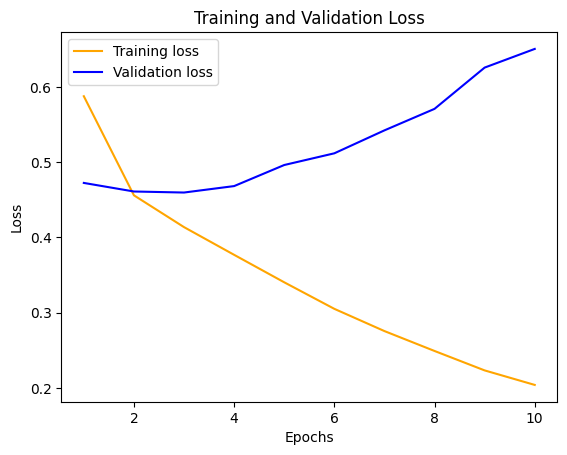

In [62]:
plot_loss(GRU_glove_history)

In [63]:
history.history['accuracy']

[0.7342700362205505,
 0.8034535050392151,
 0.8251195549964905,
 0.8418460488319397,
 0.8602237701416016,
 0.8770641088485718,
 0.8910146951675415,
 0.901249885559082,
 0.9125526547431946,
 0.9211649894714355]

In [64]:
history.history['val_accuracy']

[0.7944856882095337,
 0.8011040091514587,
 0.8038206696510315,
 0.802751362323761,
 0.7974047064781189,
 0.7948036193847656,
 0.7872604727745056,
 0.7860177159309387,
 0.783329963684082,
 0.7789081335067749]

## For 2 epochs

In [65]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our RNN layer
gru_dims = 64

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 2

# Prepossessing parameters
# We will only input the first "sequence_length" words of every Yelp review (and pad out with nulls if the text is < "sequence_length
# We will also build our model using the most frequent 20000 words in our tweet 'dictionary'
sequence_length = 200
max_features = 20000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
#num_classes = 1
num_classes = targetVar.nunique()

In [66]:
# encoder = preprocessing.LabelEncoder()
# encoder.fit(targetVar)

X = textVar.values
Y = pd.get_dummies(targetVar).values

In [67]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X,Y, stratify=targetVar, test_size = 0.33, random_state = 0)

In [68]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_labels.shape)
print(val_samples.shape,val_labels.shape)

(70248,) (70248, 3)
(34601,) (34601, 3)


In [69]:
vectorizer = TextVectorization(max_tokens  = max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [70]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'it']

In [71]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in val_samples])).numpy()

Y_train = np.array(train_labels)
Y_test = np.array(val_labels)

In [72]:
embeddings_index = {}

glove_dir = '/home/jupyter/data/wordvec/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [73]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [74]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15572 words (4428 misses)


In [75]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [76]:
# Model architecture from: https://www.kaggle.com/yekenot/pooled-gru-fasttext

inputs = Input(shape=(sequence_length, ))

x = Embedding(num_tokens, embedding_dim, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)

# Create a concatenation of GlobalAveragePooling1D and GlobalMaxPooling1D layers
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concatenated = concatenate([avg_pool, max_pool])
outputs = Dense(3, activation="softmax")(concatenated)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 200, 100)     2000200     ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 200, 100)    0           ['embedding_5[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 200, 128)    63744       ['spatial_dropout1d_2[0][0]

In [78]:
filepath="/home/jupyter/data/dl_models/gru_glove_weights_best"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

GRU_glove_history = history

Epoch 1/2
1095/1098 [============================>.] - ETA: 0s - loss: 0.5950 - accuracy: 0.7315
Epoch 1: val_accuracy improved from -inf to 0.79423, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 30ms/step - loss: 0.5947 - accuracy: 0.7316 - val_loss: 0.4788 - val_accuracy: 0.7942
Epoch 2/2
1097/1098 [============================>.] - ETA: 0s - loss: 0.4570 - accuracy: 0.8043
Epoch 2: val_accuracy improved from 0.79423 to 0.79842, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 34s 31ms/step - loss: 0.4570 - accuracy: 0.8043 - val_loss: 0.4610 - val_accuracy: 0.7984
GRU Glove model train time = 70 seconds


In [79]:
!ls -l "/home/jupyter/data/dl_models/gru_glove_weights_best"

total 1964
drwxr-xr-x 2 jupyter jupyter    4096 May 22 08:09 assets
-rw-r--r-- 1 jupyter jupyter   21877 May 24 22:27 keras_metadata.pb
-rw-r--r-- 1 jupyter jupyter 1974355 May 24 22:27 saved_model.pb
drwxr-xr-x 2 jupyter jupyter    4096 May 24 22:27 variables


In [80]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [81]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [82]:
pred_model = model.predict(X_test)
pred_model_final = np.argmax(pred_model,axis=1)

1082/1082 [==============================] - 7s 6ms/step


In [83]:
Y_test_max = np.argmax(Y_test,axis=1)

In [84]:
accuracy_score(Y_test_max, pred_model_final)  

0.7984162307447762

In [85]:
print(confusion_matrix(Y_test_max, pred_model_final))

[[ 4158  1525   116]
 [  762  8395  2420]
 [   46  2106 15073]]


In [86]:
print(classification_report(Y_test_max, pred_model_final))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      5799
           1       0.70      0.73      0.71     11577
           2       0.86      0.88      0.87     17225

    accuracy                           0.80     34601
   macro avg       0.80      0.77      0.78     34601
weighted avg       0.80      0.80      0.80     34601

